## Problem 1 :

### 1.Building the Model
__________
**1.1) Build an MLP  and choose the values of $h^1$ and $h^2$ such that the total number of parameters (including biases) falls within the range of [0.5M, 1.0M].**

The model is implemented within the NN class below.

Given that the input size is 784 and we have 10 classes, we estimaed the size of each hidden layer as follow:

- first hidden layer: 500 units
- second hidden layer: 400 units

The total number of parameters in our model with these settings is: $(784+1)*500 + (500+1)*400 + (400+1)*10 = 596910$


**1.2) Implement the forward and backward propagation of the MLP in numpy without using any of the deep learning frameworks that provides automatic differentiation.**

Our algorithm implements minibatch gradient descent, which allows us to save a lot of computation thanks to numpy's optimizations for matrix operations (we can use 1-example stochastic gradient descent by specifying batch_size = 1).

We implemented the forward and backward propagation using matrices to represent the minibatches and the neural network parameters. This way, we avoid using looped sums and replace them by numpy matrix operations.

We have also let to the user the possibility to use biases or not.

In our implementation, all matrices are transposed compared to the course notations. This has to be highlighted because it changes the order of all matrix operations.

#### Forward:
Each batch is represented by a $\mbox{batch_size} \times 784$ matrix. It can be treated as the output $H_0$ of an imaginary layer with index $0$.

For each hidden layer $i$ within $1\leq i \leq L$, we compute the preactivations matrix as $ A_{i} = H_{i-1}W_{i} + b_{i}$, with the following dimensions: 

- $A_i$ : the preactivations matrix of dimensions $\mbox{batch_size} \times h^{i}$
- $H_{i-1}$ : the postactivations matrix of dimensions $\mbox{batch_size} \times h^{i-1}$
- $W_{i}$ : the weights matrix of dimensions $h^{i-1} \times h^{i}$ ($h^i$ being the number of units of the $i^{th}$ layer)
- $b_{i}$: the biases matrix of dimensions $1 \times h^{i}$

As we can see, $H_{i-1}W_{i}$ and $b_{i}$ don't have the same first dimension, but thanks to the broadcast property provided by numpy, this is not an issue.

After using this linear transformation, we apply an activation function (for example ReLU) on $A_{i}$, which gives us $H_{i} = \mbox{activation}(A_{i})$.

The only exception is the output layer, which has a different activation function (softmax) that defines the outputs $H_{L+1}$ as a $batch\_size \times 10$ matrix of $batch\_size$ sets of total probabilities over the $10$ possible labels.

#### Backward:

We have implemented the backpropagation algorithm as follows:

The preactivation gradients of the output layer $L+1$ are represented by the $batch\_size \times 10$ matrix $\nabla A_{L+1}$, which is calculated according to:

$$
\nabla A_{L+1} = -(\mbox{true labels} - H_{L+1})
$$

(The 'true labels' matrix is a one-hot encoding of the real class of each example of the minibatch)

Then for each layer $i$ starting from $L+1$ to $1$:

- The weights gradients matrix is computed as:

$$
\nabla W_{i} = \frac{H_{i-1}^T \nabla A_i}{\mbox{batch_size}}
$$

This operation saves us a lot of computation and memory thanks to optimized matrix operations, as it computes at once the element-wise mean over the minibatch of the $\mbox{batch_size}$ matrices of dimensions $h^{i-1} \times h^{i}$ that would have been computed if we had considered each example separately. Indeed the matrix-product

$$
\underset{(h^{i-1} \times \mbox{batch_size})}{H_{i-1}^T} \underset{(\mbox{batch_size} \times h^{i})}{\nabla A_i}
$$

is the element-wise sum of the $\mbox{batch_size}$ matrices obtained for each example of the minibatch by the vector-product

$$
\underset{(h^{i-1} \times 1)}{h_{i-1}^T} \underset{(1 \times h^{i})}{\nabla a_i}
$$

presented in the course. Dividing by $\mbox{batch_size}$ gives us directly the average that has to be used for the upcoming update.

- Similarly, the biases gradients matrix is computed as:

$$
\nabla db_i = \mbox{mean over batch dimension}(\nabla A_i)
$$

which gives us a $1 \times h^{i}$ vector of the mean of the biases gradients over the minibatch, homogeneous to the $b_i$ vector as we have seen before.

- If the layer $i$ is not the layer $1$, we also need to compute $\nabla H_{i-1}$ and $\nabla A_{i-1}$ as follows:

$$
\nabla H_{i-1} = \nabla A_i \nabla W_i^T
\\
\nabla A_{i-1} = \nabla H_{i-1} \odot \mbox{activation}(A_{i-1})
$$

so we can retropropagate gradients to the previous ($i-1$) layer and compute $\nabla W_{i-1}$ and $\nabla b_{i-1}$.


**1.3) Train the MLP using the probability loss ($\textit{cross entropy}$) as training criterion. We minimize this criterion to optimize the model parameters using $\textit{stochastic gradient descent}$.**

Our algorithm minimizes the cross entropy, estimated by:

$$
- \frac{1}{N}\sum_{i=1}^{N} \mbox{true labels} * \mbox{log}(\mbox{prediction})
$$

Therefore, we use this loss function rather than accuracy to define our best model, and we keep this model in the bestWeights attribute.

In [9]:
# This part of the code implements live plotting of the train and validation loss and accuracy:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict1, title1, data_dict2, title2, figsize=(7,5), bestEpoch=0):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    for label,data in data_dict1.items():
        plt.plot(data, label=label)
        if label == 'validation accuracy':
            plt.plot(bestEpoch, data[bestEpoch], "ro")
    plt.title(title1)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.subplot(1,2,2)
    for label,data in data_dict2.items():
        plt.plot(data, label=label)
        if label == 'validation loss':
            plt.plot(bestEpoch, data[bestEpoch], "ro")
    plt.title(title2)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.show();

# This part implements the NN:
import numpy as np
import pickle
import copy
import time

"""MLP class :

The model implemented as follows :
Each layers is represented by a b vector (biases) and a W matrix (weights)
These are referenced by the weights dictionary. The format is :
self.weights[f"X{n}"] where X = b, W
NB : In our implementation, all matrices are transposed compared to the class notations
"""
class NN(object):
    
    def __init__(self,
                 hidden_dims=(1024, 2048),   # dimensions of each hidden layers
                 n_hidden=2,                 # number of hidden layers
                 mode='train',               # current mode : train/test
                 datapath=None,              # path where to find the .pkl file
                 model_path=None,            # path where to save/load the model 
                 epsilon = 1e-6,             # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                 lr = 1e-1,                  # learning rate
                 n_epochs = 1000,            # max number of epochs
                 batch_size = 1000,          # batch size for training
                 compute_biases = True,      # whether biases are used or not
                 seed = None,                # seed for reproducibility
                 activation = "relu",        # activation function
                 init_method="glorot"):      # initialization method
        """
        - method: (string) - initializes the weight matrices
            -> "zero" for a Zero initialisation of the weights
            -> "normal" for a Normal initialisation of the weights
            -> "glorot" for a Uniform initialisation of the weights
        """
        assert len(hidden_dims) == n_hidden, "Hidden dims mismatch!"
        
        self.hidden_dims = hidden_dims
        self.n_hidden = n_hidden
        self.mode = mode
        self.datapath = datapath
        self.model_path = model_path
        self.epsilon = epsilon
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.compute_biases = compute_biases
        self.init_method = init_method
        self.seed = seed
        self.activation_str = activation
        
        self.dataplot1 = collections.defaultdict(list) # history of the train and validation accuracies
        self.dataplot2 = collections.defaultdict(list) # history of the train and validation losses
        
        self.bestValLoss = np.Infinity # min value of the validation loss
        self.bestEpoch = 0 # epoch where we reached the min value of the validation loss
        self.bestWeights = None # optimal weights dictionary (contains biases when compute_biases=True)
        
        # train, validation and test sets :
        if datapath.lower().endswith(".npy"):
            self.tr, self.va, self.te = np.load(open(datapath, "rb"))
        elif datapath.lower().endswith(".pkl"):
            u = pickle._Unpickler(open(datapath, 'rb'))
            u.encoding = 'latin1'
            self.tr, self.va, self.te = u.load()
        else:
            raise Exception("Unknown data source type!")
    
    def initialize_weights(self, dims):
        """
        Initializes the weights and biases according to the specified method :
        - dims: (list of two integers) - the size of input/output layers
        :return: None
        """
        if self.seed is not None:
            np.random.seed(self.seed)
        if self.mode == "train":
            self.weights = {}
            all_dims = [dims[0]] + list(self.hidden_dims) + [dims[1]]
            #print("Layers dimensions are : ", all_dims)
            for layer_n in range(1, self.n_hidden + 2):
                if self.init_method == "zero":
                    self.weights[f"W{layer_n}"] = np.zeros(shape=(all_dims[layer_n - 1],all_dims[layer_n])).astype('float64')
                elif self.init_method == "normal":
                    #Be aware of the error you get "true divide", can be solved by dividing by dim_layer[n-1] 
                    self.weights[f"W{layer_n}"] = np.random.normal(loc=0.0, scale=1.0, size=(all_dims[layer_n - 1],
                                                                                             all_dims[layer_n])).astype('float64')/all_dims[layer_n-1]
                elif self.init_method == "glorot":
                    b = np.sqrt(6.0/(all_dims[layer_n]+all_dims[layer_n-1]))
                    self.weights[f"W{layer_n}"] = np.random.uniform(low=-b, high=b, size=(all_dims[layer_n - 1],
                                                                                            all_dims[layer_n])).astype('float64')
                else:
                    raise Exception("The provided name for the initialization method is invalid.")
                
                if self.compute_biases:
                    self.weights[f"b{layer_n}"] = np.zeros((1, all_dims[layer_n]))
                    
        elif self.mode == "test": # test mode is to load the weights of an existing model
            self.weights = np.load(self.model_path)
        else:
            raise Exception("Unknown Mode!")
    
    def relu(self,x, prime=False):# Prime for Step function, else ReLu
        if prime:
            return x > 0
        return np.maximum(0, x)
    
    def sigmoid(self,x, prime=False):
        if prime:
            return self.sigmoid(x)*(1 -  self.sigmoid(x))
        return 1/(1 + np.exp(-x))
    
    def tanh(self,x, prime=False):
        if prime:
            return 1 -  np.power(self.tanh(x),2)
        return np.tanh(x)
    
    def activation(self, input_, prime=False):  
        if self.activation_str == "relu":
            return self.relu(input_,prime)
        elif self.activation_str == "sigmoid":
            return self.sigmoid(input_,prime)
        elif self.activation_str == "tanh":
            return self.tanh(input_,prime)
        else:
            raise Exception("Unsupported activation!")

    def softmax(self, input_):  # Computes the softmax of the input
        """
        Documentation
        """
        Z = np.exp(input_ - np.max(input_)) # softmax(x-C) = softmax(x) (stability)
        return Z / np.sum(Z, axis=1, keepdims=True)
    
    def forward(self, input_):  # Forward propagation : computes the outputs (cache) from the input
        """
        Documentation
        """
        cache = {"H0": input_}
        for layer in range(1, self.n_hidden + 1):
            if self.compute_biases:
                cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"] + self.weights[f"b{layer}"]
            else:
                cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"]
            cache[f"H{layer}"] = self.activation(cache[f"A{layer}"])

        layer = self.n_hidden + 1
        if self.compute_biases:
            cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"] + self.weights[f"b{layer}"]
        else:
            cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"]
        cache[f"H{layer}"] = self.softmax(cache[f"A{layer}"]) # softmax on last layer
        return cache
    
    def backward(self, cache, labels):  # Backward propagation : computes the gradients from the outputs (cache)
        """
        Documentation
        """
        output = cache[f"H{self.n_hidden+1}"]
        grads = {f"dA{self.n_hidden+1}": - (labels - output)}
        for layer in range(self.n_hidden + 1, 0, -1):
            # the following operation averages at once all the matrices
            # that we would have calculated for each example of the minibatch if we had not represented it in matrix form :
            grads[f"dW{layer}"] = cache[f"H{layer-1}"].T @ grads[f"dA{layer}"] / self.batch_size
            # we need to do the same for the biases gradients :
            if self.compute_biases:
                grads[f"db{layer}"] = np.mean(grads[f"dA{layer}"], axis=0, keepdims=True)
            if layer > 1:
                grads[f"dH{layer-1}"] = grads[f"dA{layer}"] @ self.weights[f"W{layer}"].T
                grads[f"dA{layer-1}"] = grads[f"dH{layer-1}"] * self.activation(cache[f"A{layer-1}"], prime=True)
        return grads
    
    def update(self, grads):  # To update the weights and the biases
        """
        Documentation
        """
        for layer in range(1, self.n_hidden + 1):
            self.weights[f"W{layer}"] = self.weights[f"W{layer}"] - self.lr * grads[f"dW{layer}"]
            if self.compute_biases:
                self.weights[f"b{layer}"] = self.weights[f"b{layer}"] - self.lr * grads[f"db{layer}"]
    
    def loss(self, prediction, labels):  # Computes the cross entropy
        """
        Documentation
        """
        prediction[np.where(prediction < self.epsilon)] = self.epsilon
        prediction[np.where(prediction > 1 - self.epsilon)] = 1 - self.epsilon
        return -1 * np.sum(labels * np.log(prediction)) / prediction.shape[0]
    
    def computeLossAndAccuracy(self, X, y):  # Stores the accuracy/loss of the train/validation sets
        """
        Documentation
        """
        on_y = self._one_hot(y)
        vCache = self.forward(X)
        vOut = np.argmax(vCache[f"H{self.n_hidden + 1}"], axis=1)
        vAccuracy = np.mean(y == vOut)
        vLoss = self.loss(vCache[f"H{self.n_hidden+1}"], on_y)
        return vLoss, vAccuracy, vOut
    
    def _one_hot(self,y):
        """
        Documentation
        """
        _, y_train = self.tr
        return np.eye(np.max(y_train) - np.min(y_train) + 1)[y]
    
    def train(self,show_graph = True, save_model = True):
        """
        Documentation
        """
        X_train, y_train = self.tr
        y_onehot = self._one_hot(y_train)
        dims = [X_train.shape[1], y_onehot.shape[1]]
        self.initialize_weights(dims)
        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))

        for epoch in range(self.n_epochs):
            predictedY = np.zeros_like(y_train)
            for batch in range(n_batches):
                minibatchX = X_train[self.batch_size * batch:self.batch_size * (batch + 1), :]
                minibatchY = y_onehot[self.batch_size * batch:self.batch_size * (batch + 1), :]
                cache = self.forward(minibatchX)
                grads = self.backward(cache, minibatchY)
                self.update(grads)
                predictedY[self.batch_size * batch:self.batch_size * (batch + 1)] = np.argmax(
                    cache[f"H{self.n_hidden + 1}"], axis=1)
                
            X_tr, y_tr = self.tr
            trLoss, trAccuracy,_ = self.computeLossAndAccuracy(X_tr, y_tr)
            X_val, y_val = self.va
            valLoss, valAccuracy,_ = self.computeLossAndAccuracy(X_val, y_val)
            
            if valLoss < self.bestValLoss:
                self.bestValLoss = valLoss
                self.bestEpoch = epoch
                self.bestWeights = copy.deepcopy(self.weights)
            
            self.dataplot1['train accuracy'].append(trAccuracy)
            self.dataplot1['validation accuracy'].append(valAccuracy)
            self.dataplot2['train loss'].append(trLoss)
            self.dataplot2['validation loss'].append(valLoss)
            if show_graph:
                live_plot(self.dataplot1, "Accuracy", self.dataplot2, "Loss", (14,5), self.bestEpoch)
        
        if save_model:
            # Save Best Model
            if self.model_path is None:
                string_hdims = "-".join(map(str,self.hidden_dims))
                model_name = f"best-model-init-{self.init_method}-lr-{self.lr}-hdims-{string_hdims}-batches-{self.batch_size}.npz"
                np.savez(model_name,**self.bestWeights)
            else:
                np.savez(self.model_path,**self.bestWeights)
            
        return self.dataplot1, self.dataplot2
    
    def test(self):
        """
        Documentation
        """
        X_te, y_te = self.te
        vLoss, vAccuracy,_ = self.computeLossAndAccuracy(X_te, y_te)
        print(f"Test Accuracy:{vAccuracy}, Test Loss:{vLoss}")

For the following questions, the architecture we chose is a 2-layer neural network of size $(500, 400)$. The batch size is $100$, and the learning rate is $0.5$, which we found converges very quickly with this setting.

### 2. Initialization

**2.1) Train the model for 10 epochs using the initialization methods and record the average loss measured on the training data at the end of each epoch (10 values for each setup).**

**- Initialization with zeros:**

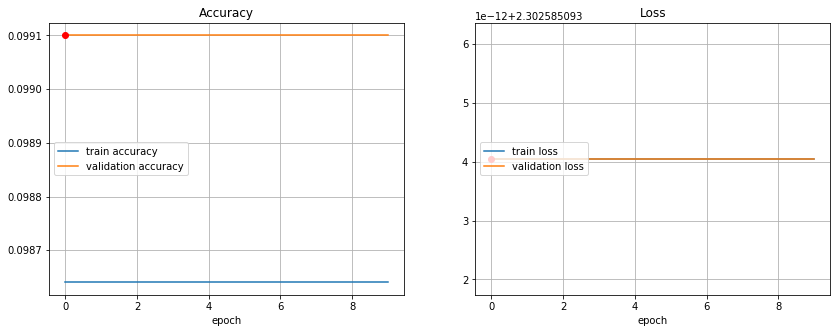

In [11]:
#Zero_Init
neural_net = NN(hidden_dims=(500, 400),
                n_hidden=2,                  # number of hidden layers
                mode='train',                # current mode : train/test
                datapath="mnist.npy",        # path where to find the .pkl file
                model_path=None,             # path where to save/load the model 
                epsilon = 1e-8,              # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                lr = 5e-1,                   # learning rate
                n_epochs = 10,               # max number of epochs
                batch_size = 100,            # batch size for training
                compute_biases = True,       # whether biases are used or not
                init_method = "zero")        # initialization method
_,_ = neural_net.train()

**- Initialization with a Standard Normal distribution:**

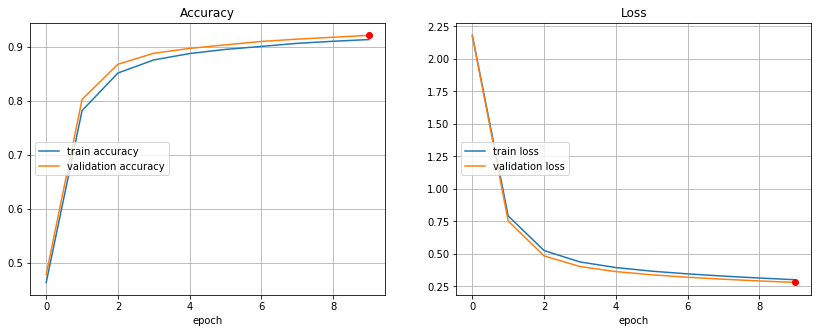

In [6]:
#Normal init
neural_net = NN(hidden_dims=(500, 400),
                n_hidden=2,                  # number of hidden layers
                mode='train',                # current mode : train/test
                datapath="mnist.pkl",        # path where to find the .pkl file
                model_path=None,             # path where to save/load the model 
                epsilon = 1e-8,              # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                lr = 5e-1,                   # learning rate
                n_epochs = 10,               # max number of epochs
                batch_size = 100,            # batch size for training
                compute_biases = True,       # whether biases are used or not
                init_method = "normal")      # initialization method
normal_hist_acc, normal_hist_loss = neural_net.train()

**- Initialization with Glorot method:**

In [ ]:
#Glorot_Init
neural_net = NN(hidden_dims=(500, 400),
                n_hidden=2,                  # number of hidden layers
                mode='train',                # current mode : train/test
                datapath="mnist.npy",        # path where to find the .pkl file
                model_path=None,             # path where to save/load the model 
                epsilon = 1e-8,              # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                lr = 5e-1,                   # learning rate
                n_epochs = 10,               # max number of epochs
                batch_size = 100,            # batch size for training
                compute_biases = True,       # whether biases are used or not
                init_method = "glorot")      # initialization method
glorot_hist_acc, glorot_hist_loss = neural_net.train()

**2.2) Compare the three setups by plotting the losses against the training time (epoch) and comment on the result.**

- Zero initialization for the weights leads to no change at all in accuracy. We can indeed show that doing so will lead to no possible update of the weights during the retropropagation, as

$$
\nabla H_{i-1} = \nabla A_i \nabla W_i^T
$$

will give zero gradients. Actually, only the biases of the last layer will be changed according to

$$
\nabla A_{L+1} = -(\mbox{true labels} - H_{L+1})\\
\mbox{and}\\
\nabla db_i = \mbox{mean over batch dimension}(\nabla A_i)
$$

in such a way that will not impact the predictions over each example from an epoch to another.

- If we simply generate the weights following a normal distribution $N(0,1)$, this leads to quick numeric explosion and errors. Indeed, weights will add up and are likely to lead to exponential overflows (or zero divisions in our stabilized softmax). We chose to tackle this issue by dividing the normal weights by the dimension of the previous layer. This way, preactivation values will stay around \[-1,1\] at each layer. After 10 epochs, this initialization method leads to a 91% accuracy and no overfitting (the model needs to train more).

- If we use the formula from Glorot, Bengio - 2010, we observe extremely fast convergence as the validation accuracy reaches 96% after the first epoch (versus 48% for normal initialization) and the model starts overfitting (regarding the cross-entropy loss) at more than 98% accuracy after only 7 epochs.

### 3. Hyperparameter Search

**3.1) Find out a combination of hyper-parameters (model architecture, learning rate, nonlinearity, etc.) such that the average accuracy rate on the validation set ($r^{(valid)}$) is at least 97\%.**

Although we have found a model that performs better than 98% relatively quickly by hand, in this part we perform a random search in hope to find a better model.

In [30]:
class RandomSearch:
    
    def __init__(self, model, params, n_itters, seed = 42):
        self.params = params # parameters assignation grid (dictionary)
        self.n_itters = n_itters # number of searches
        self.model = model # NN class to use for random search
        self.seed = seed # seed for reproducibility
        
    def run(self):

        #np.random.seed(self.seed)
        results = []
        best_acc = None
        best_loss = None
        params = [p for p in self._generate_grid()]
        for it, selected_params in enumerate(params):
            try:
                print(f"{it}","-".join(map(lambda x: str(x),selected_params.items())))
                instance_model = self.model(seed = self.seed,**selected_params)
                acc, loss = instance_model.train(show_graph=False,save_model=False)
                id_best = np.argmin(loss["validation loss"])

                results.append((selected_params, loss["validation loss"][id_best], acc["validation accuracy"][id_best]))

                if best_acc is None or best_loss> loss["validation loss"][id_best]:
                    print(f"Found a better model: Accuracy from {best_acc} to {acc['validation accuracy'][id_best]}")
                    best_loss = loss["validation loss"][id_best]
                    best_acc  = acc["validation accuracy"][id_best]
                print(f'Model {it+1}, accuracy {acc["validation accuracy"][id_best]:.5f}, loss {loss["validation loss"][id_best]:.5f}, Best Model: acc {best_acc:.5f}, loss {best_loss:.5f}')
            except KeyboardInterrupt:
                break
        return results
    
    def _generate_grid(self):
        for it in range(self.n_itters):
            yield self._select_params()
    def _select_params(self):
        selected_params = {}
        for key,value in self.params.items():
            if key == "hidden_dims":
                continue
            elif key == "n_hidden":
                assert type(value) == int and value>0
                hidden_units = []
                for _ in range(value):
                    hidden_units.append(np.random.choice(self.params["hidden_dims"]))
                selected_params["hidden_dims"] = hidden_units
                selected_params[key]=value
            elif type(value)==list or type(value)==tuple:
                selected_params[key] = np.random.choice(self.params[key])
            else:
                selected_params[key]=value
        return selected_params
    

In [32]:
grid_params = {
    "hidden_dims":[400,500,600],
    "n_hidden":2,
    "lr":[.3,.5,.7],
    "n_epochs":[10,15,20],
    "batch_size":[75,100,125],
    "activation":["tanh","sigmoid","relu"],
    "datapath":"mnist.npy",
}

rd_search = RandomSearch(
    model = NN,
    params = grid_params,
    n_itters = 10
)
experiments = rd_search.run()

0 ('hidden_dims', [600, 400])-('n_hidden', 2)-('lr', 0.5)-('n_epochs', 10)-('batch_size', 125)-('activation', 'tanh')-('datapath', 'mnist.npy')
Found a better model: Accuracy from None to 0.9773
Model 1, accuracy 0.97730, loss 0.08203, Best Model: acc 0.97730, loss 0.08203
1 ('hidden_dims', [500, 400])-('n_hidden', 2)-('lr', 0.5)-('n_epochs', 20)-('batch_size', 75)-('activation', 'sigmoid')-('datapath', 'mnist.npy')
Model 2, accuracy 0.96310, loss 0.13616, Best Model: acc 0.97730, loss 0.08203
2 ('hidden_dims', [400, 600])-('n_hidden', 2)-('lr', 0.5)-('n_epochs', 10)-('batch_size', 75)-('activation', 'sigmoid')-('datapath', 'mnist.npy')
Model 3, accuracy 0.95220, loss 0.17978, Best Model: acc 0.97730, loss 0.08203
3 ('hidden_dims', [600, 400])-('n_hidden', 2)-('lr', 0.5)-('n_epochs', 15)-('batch_size', 100)-('activation', 'sigmoid')-('datapath', 'mnist.npy')
Model 4, accuracy 0.95080, loss 0.18353, Best Model: acc 0.97730, loss 0.08203
4 ('hidden_dims', [600, 400])-('n_hidden', 2)-('lr

In [57]:

from collections import defaultdict

output = defaultdict(list)
for obs in experiments:
    for key,val in obs[0].items():
        output[key].append(val)
    output["loss"].append(obs[1])
    output["accuracy"].append(obs[2])

import pandas as pd
sorted_output= pd.DataFrame(output)
sorted_output.sort_values(by="accuracy",ascending=False)

,hidden_dims,n_hidden,lr,n_epochs,batch_size,activation,datapath,loss,accuracy
4,"[600, 400]",2,0.7,10,75,relu,mnist.npy,0.066636,0.9801
8,"[400, 400]",2,0.3,15,100,tanh,mnist.npy,0.071301,0.9788
9,"[600, 400]",2,0.3,10,125,relu,mnist.npy,0.071917,0.9788
6,"[600, 600]",2,0.3,10,125,relu,mnist.npy,0.069855,0.9787
0,"[600, 400]",2,0.5,10,125,tanh,mnist.npy,0.082031,0.9773
5,"[500, 600]",2,0.3,10,100,tanh,mnist.npy,0.083797,0.9752
1,"[500, 400]",2,0.5,20,75,sigmoid,mnist.npy,0.136157,0.9631
7,"[400, 500]",2,0.7,15,125,sigmoid,mnist.npy,0.166307,0.9559
2,"[400, 600]",2,0.5,10,75,sigmoid,mnist.npy,0.179784,0.9522
3,"[600, 400]",2,0.5,15,100,sigmoid,mnist.npy,0.183532,0.9508
